In [9]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy.polynomial.polynomial as poly
import scipy.sparse as sp
import scipy.sparse.linalg



In [10]:
def set_init(c,d, n,x):
    """set_init(c,d,n,x)=c + d* \sum_{i=1}^n (cos(2pi*jx)/j).
    This provides the initial conditions for the model."""
    val = c
    for j in range(1, n+1):
        val = val + d*(np.cos(2*np.pi*j*x))/j
    return val


In [11]:
#Initial conditions for Example 1
u_0= lambda x: set_init(0.919145,0.001,25,x)
v_0 = lambda x: set_init(0.937903, 0.001, 25, x)

h = 0.01 #Mesh size=0.01

def F(a, b, gamma, U,V):
    """Reaction term. f(u,v)=[\gamma (a-u+u^2v), \gamma (b-(u^2)v)]"""
    return (gamma*(a-U+U*U*V), gamma*(b-U*U*V))

def lap_bc(N):
    """Construct a discrete Laplacian matrix with periodic boundary conditions"""
    
    diag0=np.ones(N)
    diag1= -2*np.ones(N)
    diag2= np.ones(N)
    L= sp.spdiags([diag0, diag1, diag2], [-1,0,1], N, N)
    L=L.tolil()
    L[0,N-1]=1
    L[N-1,0]=1
    L=L.tocsc()
    return L

def sbdf_1(N,dt,M,a, b, gamma, u0,v0):
    """Performs M iterations of 1-sbdf with timestep dt"""
    
    #Set initial conditions, spatial mesh.
    h = 1/N
    xs  = np.arange(0,N)*h
    U = np.empty(shape=(M+1,N))
    V=np.empty(shape=(M+1,N))
    U[0]=u0(xs)
    V[0]=v0(xs)
    
    iden = sp.eye(N)
    L = lap_bc(N)
    A = iden -(dt/h**2)*L
    B = iden -(10*dt/h**2)*L

    for m in range(1,M+1):
        #Calculate reaction term
        (fu,fv) = F(a, b, gamma, U[m-1],V[m-1])
        
        #Solve for next iteration
        U[m] = sp.linalg.spsolve(A, U[m-1]+dt*fu)
        V[m] = sp.linalg.spsolve(B, V[m-1]+dt*fv)
        
    return (U,V)


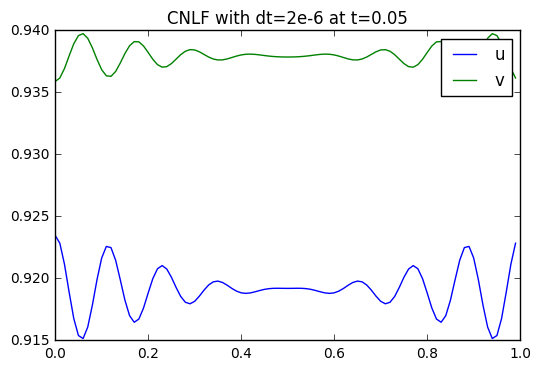

In [59]:
# N=100, dt=2e-5, M=2500, a=0.126779, b=0.792366, gamma=10000
(u,v)=cnlf(100,2e-6,2500,0.126779,0.792366,10000,u_0,v_0)
x=np.arange(0,100)*0.01
plt.figure()
plt.plot(x,u[2500],label='u')
plt.plot(x,v[2500],label='v')
plt.title('CNLF with dt=2e-6 at t=0.05')
plt.legend()
plt.show()






In [54]:
def cnab(N,dt,M,a, b, gamma, u0,v0):
    """Performs M iterations of cnab with timestep dt"""
    
    #Set initial conditions, spatial mesh.
    h = 1/N
    xs  = np.arange(0,N)*h
    U = np.empty(shape=(M+1,N))
    V=np.empty(shape=(M+1,N))
    U[0]=u0(xs)
    V[0]=v0(xs)
    
    iden = sp.eye(N)
    L = lap_bc(N)
    A1 = iden -(dt/h**2)*L
    A2 = iden +(dt/h**2)*L
    B1 = iden -(10*dt/h**2)*L
    B2 = iden +(10*dt/h**2)*L
    
    #(fu0,fv0) = F(a, b, gamma, U[0],V[0])
    #U[1] = sp.linalg.spsolve(A1, A2.dot(U[0]) + dt*fu0)
    #V[1] = sp.linalg.spsolve(B1, B2.dot(V[0]) + dt*fv0)
    (u,v)=sbdf_1(N,dt*0.01,M*100,a,b,gamma,u0,v0)
    U[1]=u[1]
    V[1]=v[1]
    
    for m in range(2,M+1):
        #Calculate reaction terms
        (fu1,fv1) = F(a, b, gamma, U[m-1],V[m-1])
        (fu2,fv2) = F(a, b, gamma, U[m-2],V[m-2])
        
        #Solve for next iteration
        U[m] = sp.linalg.spsolve(A1, A2.dot(U[m-1])
                                 + (dt*3/2)*fu1 - (dt/2)*fu2)
        V[m] = sp.linalg.spsolve(B1, B2.dot(V[m-1])
                                 + (dt*3/2)*fv1 - (dt/2)*fv2)
        
    return (U,V)

def mcnab(N,dt,M,a, b, gamma, u0,v0):
    """Performs M iterations of mcnab with timestep dt"""
    
    #Set initial conditions, spatial mesh.
    h = 1/N
    xs  = np.arange(0,N)*h
    U = np.empty(shape=(M+1,N))
    V=np.empty(shape=(M+1,N))
    U[0]=u0(xs)
    V[0]=v0(xs)
    
    iden = sp.eye(N)
    L = lap_bc(N)
    A1 = iden -(9*dt/(16*h**2))*L
    A2 = iden +(3*dt/(8*h**2))*L
    A = iden + (7*dt/(16*h**2)) * L
    B1 = iden -(90*dt/(16*h**2))*L
    B2 = iden +(30*dt/(8*h**2))*L
    B = iden +(70*dt/(16*h**2))*L
    
    
    for m in range(1,M+1):
        #Calculate reaction terms
        (fu1,fv1) = F(a, b, gamma, U[m-1],V[m-1])
        
        if m == 1:
            U[1] = sp.linalg.spsolve(A1, A.dot(U[0])
                                     + dt*fu1)
            V[1] = sp.linalg.spsolve(B1, B.dot(V[0])
                                     + dt*fv1)
        
        #Solve for next iteration
        else:
            (fu2,fv2) = F(a, b, gamma, U[m-2],V[m-2])
            
            U[m] = sp.linalg.spsolve(A1, A2.dot(U[m-1])
                                     + (dt/16)*L.dot(U[m-2]) 
                                     + dt*3*fu1/2 - (dt/2)*fu2)
            V[m] = sp.linalg.spsolve(B1, B2.dot(V[m-1])
                                     + (10*dt/16)*L.dot(U[m-2])
                                     + dt*3*fv1/2 - (dt/2)*fv2)
        
    return (U,V)

In [18]:
def cnlf(N,dt,M,a, b, gamma, u0,v0):
    """Performs M iterations of cnab with timestep dt"""
    
    #Set initial conditions, spatial mesh.
    h = 1/N
    xs  = np.arange(0,N)*h
    U = np.empty(shape=(M+1,N))
    V=np.empty(shape=(M+1,N))
    U[0]=u0(xs)
    V[0]=v0(xs)
    
    iden = sp.eye(N)
    L = lap_bc(N)
    A1 = iden -(dt/h**2)*L
    A2 = iden +(dt/h**2)*L
    B1 = iden -(10*dt/h**2)*L
    B2 = iden +(10*dt/h**2)*L
  
    for m in range(1,M+1):
        #Calculate reaction terms
        (fu1,fv1) = F(a, b, gamma, U[m-1],V[m-1])
        
        if m == 1:
            U[1] = sp.linalg.spsolve(A1, A2.dot(U[0])+dt*fu1)
            V[1] = sp.linalg.spsolve(B1, B2.dot(V[0])+dt*fv1)
        else:
            (fu2,fv2) = F(a, b, gamma, U[m-2],V[m-2])
            
            #Solve for next iteration
            U[m] = sp.linalg.spsolve(A1, A2.dot(U[m-2])
                                     + 2*dt*fu1)
            V[m] = sp.linalg.spsolve(B1, B2.dot(V[m-2]) 
                                     + 2*dt*fv1)
        
    return (U,V)

def sbdf_2(N,dt,M,a, b, gamma, u0,v0):
    """Performs M iterations of cnab with timestep dt"""
    
    #Set initial conditions, spatial mesh.
    h = 1/N
    xs  = np.arange(0,N)*h
    U = np.empty(shape=(M+1,N))
    V=np.empty(shape=(M+1,N))
    U[0]=u0(xs)
    V[0]=v0(xs)
    
    iden = sp.eye(N)
    L = lap_bc(N)
    A = 3*iden -(2*dt/h**2)*L
    A1 = iden -(dt/h**2)*L
    B = 3*iden -(20*dt/h**2)*L
    B1 = iden -(10*dt/h**2)*L
    
    for m in range(1,M+1):
        #Calculate reaction terms
        (fu1,fv1) = F(a, b, gamma, U[m-1],V[m-1])
        
        if m == 1:
            U[1] = sp.linalg.spsolve(A1, U[0]+dt*fu1)
            V[1] = sp.linalg.spsolve(B1, V[0]+dt*fv1)
        else:
            (fu2,fv2) = F(a, b, gamma, U[m-2],V[m-2])
            
            #Solve for next iteration
            U[m] = sp.linalg.spsolve(A, 4*U[m-1]-U[m-2]
                                     + 4*dt*fu1-2*dt*fu2)
            V[m] = sp.linalg.spsolve(B, 4*V[m-1]-V[m-2]
                                     + 4*dt*fv1-2*dt*fv2)
        
    return (U,V)


In [88]:
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 1))
ax.set_ylim((0.5, 1.4))

line, = ax.plot([], [], lw=0.5)

(u2,v2)=mcnab(100,2e-5,50000,0.126779,0.792366,10000,u_0,v_0)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = np.arange(0,100)/100
    y = u2[i]
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=np.arange(0,5000,100), interval=100, blit=True)

In [89]:
rc('animation', html='html5')
anim

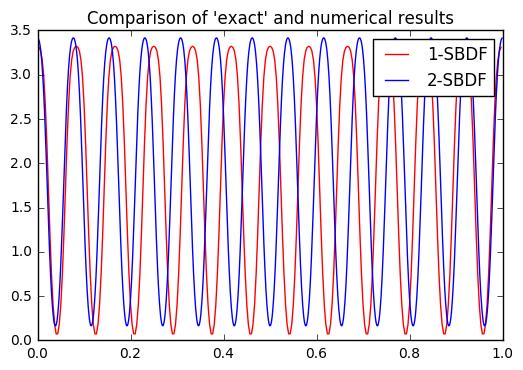

In [76]:
# N=100, dt=2e-5, M=2500, a=0.126779, b=0.792366, gamma=10000. 
# t= 0.05
#uin=lambda x: set_init(1.886485,0.001,37,x)
#vin = lambda x: set_init(0.779539, 0.001, 37, x)


#(u,v)=sbdf_1(300,5e-6,20000,-0.887757,2.774242,10000,uin,vin)
#(us,vs)=sbdf_2(900,1e-6,100000,-0.887757,2.774242,10000,uin,vin)
x=np.arange(0,300)/300
xs=np.arange(0,900)/900
plt.figure()

plt.plot(x,u[20000], label='1-SBDF',color='red')
plt.plot(xs,us[100000],label='2-SBDF',color='blue')
plt.title("Comparison of 'exact' and numerical results")
plt.legend()
plt.show()



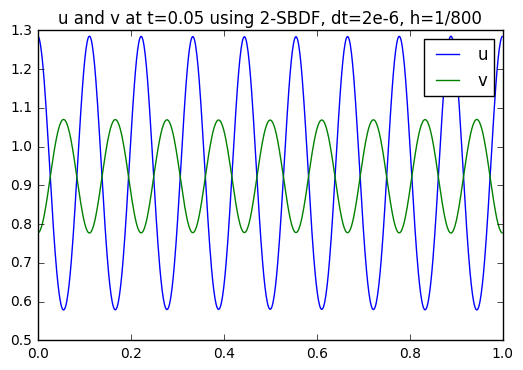

In [50]:
# N=800, dt=2e-6, M=25000, a=0.126779, b=0.792366, gamma=10000. 
# t= 0.05
(u2,v2)=sbdf_2(800,2e-6,25000,0.126779,0.792366,10000,u_0,v_0)
x2 = np.arange(0,800)/800
plt.figure()
plt.plot(x2,u2[25000], label='u')
plt.plot(x2,v2[25000], label='v')
plt.title("u and v at t=0.05 using 2-SBDF, dt=2e-6, h=1/800")
plt.legend()
plt.show()


In [25]:
#Initial conditions for example 2
u_1= lambda x: set_init(4.949748,0.001,50,x)
v_1 = lambda x: set_init(0.8081219, 0.001, 50, x)


In [31]:
#Baseline for example 2: 2-SBDF with dt=1e-7, h=1/1000 (N=1000), t=0.2
#a=-14.849242, b=19.79899, gamma=1000

(u22,v22) = sbdf_2(1000,1e-7,2000000, -14.849242,19.79899,1000,u_1,v_1)


In [32]:
u22[0]

array([ 4.95424721,  4.95422214,  4.95414821,  4.95402908,  4.9538706 ,
        4.95368043,  4.95346749,  4.95324144,  4.95301204,  4.95278854,
        4.95257916,  4.95239062,  4.9522278 ,  4.95209356,  4.95198867,
        4.95191195,  4.95186049,  4.95183001,  4.95181527,  4.95181057,
        4.95181021,  4.95180893,  4.95180231,  4.951787  ,  4.95176098,
        4.95172354,  4.95167526,  4.95161783,  4.95155381,  4.95148636,
        4.95141882,  4.95135446,  4.95129614,  4.95124608,  4.95120565,
        4.95117535,  4.95115473,  4.95114256,  4.95113691,  4.95113541,
        4.95113548,  4.95113459,  4.95113048,  4.95112136,  4.95110607,
        4.95108414,  4.95105583,  4.95102205,  4.95098423,  4.9509442 ,
        4.95090397,  4.9508655 ,  4.95083059,  4.95080063,  4.95077652,
        4.9507586 ,  4.95074663,  4.95073981,  4.95073693,  4.95073644,
        4.95073666,  4.9507359 ,  4.95073268,  4.9507258 ,  4.9507145 ,
        4.95069851,  4.95067803,  4.95065373,  4.95062665,  4.95

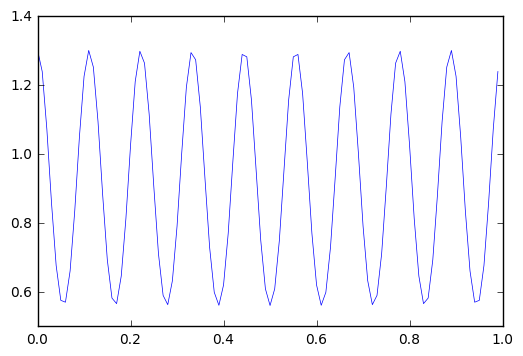

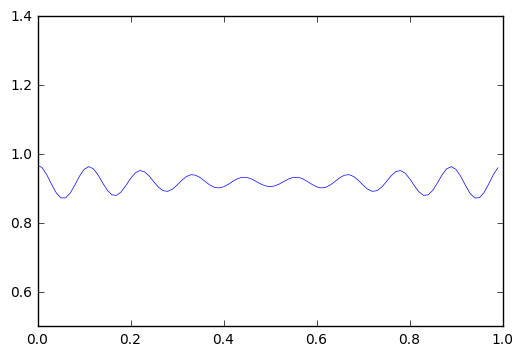

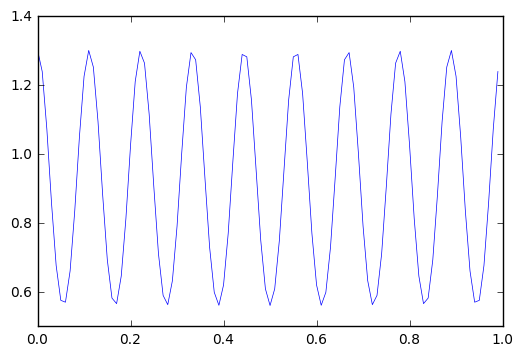

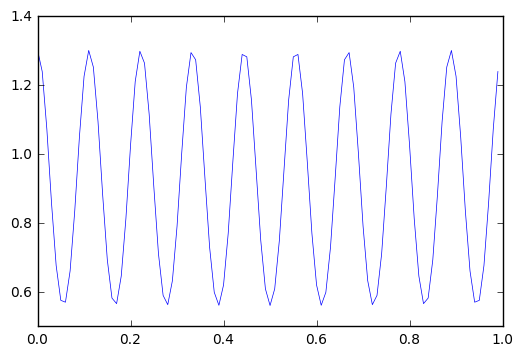

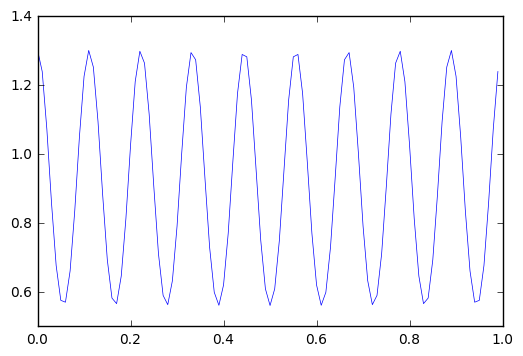

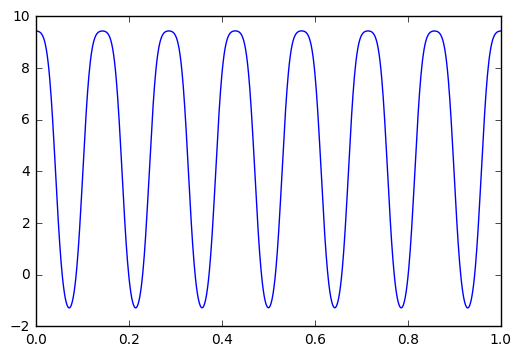

In [95]:
plt.figure()
x=np.arange(0,1000)/1000
plt.plot(x,u22[1000000])
plt.show()

In [87]:
range(0,50000,500)

range(0, 50000, 500)

In [94]:
anim.save('ex1.mp4')